# EnKF Experiments - GCS

## Imports

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.stats import shapiro, kruskal
import seaborn as sns
import sys

In [2]:
sys.path.append('../../../../stationsim/')
from ensemble_kalman_filter import EnsembleKalmanFilter, AgentIncluder
from stationsim_gcs_model import Model

In [3]:
sys.path.append('../')
from experiment_utils import Modeller, Processor, Visualiser

In [4]:
%matplotlib inline
np.random.seed(42)

## Functions

In [5]:
def tidy_dataframe(df, independent_col: str, dependent_cols: list):
    output = list()
    
    for i, row in df.iterrows():
        for col in dependent_cols:
            d = {independent_col: row[independent_col],
                 'variable':  col,
                 'value': row[col]}
            output.append(d)
    
    output = pd.DataFrame(output)
    return output

## Data paths

In [6]:
data_dir = '../results/data/exp1/'
model_dir = '../results/models/exp1/'
fig_dir = '../results/figures/exp1/'

## Experiment 1 - Setting Up EnKF

### Base model inclusion in error calculations

In [7]:
# Modeller.run_experiment_1(pop_size=20, inclusion=AgentIncluder.MODE_EN)

In [8]:
Processor.process_experiment_1()

#### Read data

In [9]:
results = pd.read_csv(data_dir + 'p20/metrics.csv')
results.head()

,time,forecast,obs,analysis,analysis_0,analysis_1,analysis_2,analysis_3,analysis_4,analysis_5,...,analysis_11,analysis_12,analysis_13,analysis_14,analysis_15,analysis_16,analysis_17,analysis_18,analysis_19,baseline
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20,45.195195,0.827537,0.281233,0.737668,0.474341,0.920247,0.416409,0.601326,0.223056,...,1.394070,0.709399,0.212519,0.410753,0.545496,1.572144,0.170481,0.483321,0.478022,64.181255
2,40,6.056728,1.206179,0.702330,0.906580,0.558394,0.938502,0.446845,1.140773,0.873259,...,0.938170,1.567501,0.657353,0.476745,0.763484,1.275902,1.083473,0.462785,0.562063,43.388943
3,60,10.058279,1.833711,0.544053,0.419511,0.401792,1.006703,0.864303,1.047906,1.485260,...,0.767431,0.706596,0.337290,0.614600,0.735850,0.581805,1.414973,0.291528,0.484728,42.351277
4,80,13.613127,1.139485,0.574179,0.715747,0.939574,0.533344,0.764006,0.685907,0.867158,...,1.162537,0.566900,0.943481,0.614970,0.532816,0.712951,0.970158,0.681870,0.574174,41.974411


In [10]:
results.shape

(190, 25)

#### Tidy up data

In [11]:
results_cols = list(results)
error_types = [c for c in results_cols if c != 'time']

In [12]:
base_error_types = ['forecast', 'obs', 'analysis', 'baseline']
ensemble_error_types = [e for e in error_types if e not in base_error_types]

In [13]:
base_error_types

['forecast', 'obs', 'analysis', 'baseline']

In [14]:
ensemble_error_types

['analysis_0',
 'analysis_1',
 'analysis_2',
 'analysis_3',
 'analysis_4',
 'analysis_5',
 'analysis_6',
 'analysis_7',
 'analysis_8',
 'analysis_9',
 'analysis_10',
 'analysis_11',
 'analysis_12',
 'analysis_13',
 'analysis_14',
 'analysis_15',
 'analysis_16',
 'analysis_17',
 'analysis_18',
 'analysis_19']

In [15]:
base_tidy_df = tidy_dataframe(results, 'time', base_error_types)
base_tidy_df.head()

,time,variable,value
0,0.0,forecast,NaN
1,0.0,obs,NaN
2,0.0,analysis,NaN
3,0.0,baseline,NaN
4,20.0,forecast,45.195195


In [16]:
ensemble_tidy_df = tidy_dataframe(results, 'time', ensemble_error_types)
ensemble_tidy_df.head()

,time,variable,value
0,0.0,analysis_0,NaN
1,0.0,analysis_1,NaN
2,0.0,analysis_2,NaN
3,0.0,analysis_3,NaN
4,0.0,analysis_4,NaN


### Ensemble member errors

In [21]:
ensemble_mean = base_tidy_df.loc[base_tidy_df['variable']=='analysis', :]

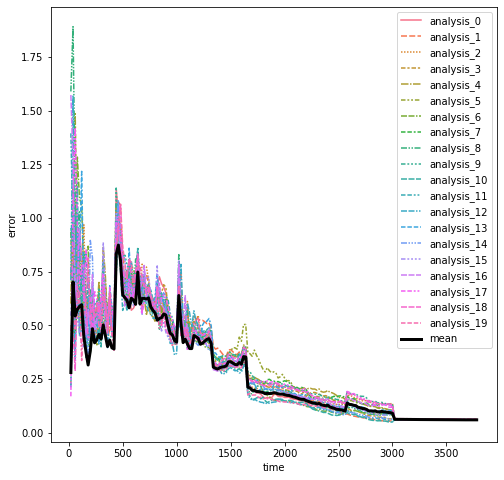

In [33]:
plt.figure(figsize=(8, 8))
sns.lineplot(x='time', y='value', hue='variable', style='variable', data=ensemble_tidy_df)
plt.plot(ensemble_mean['time'], ensemble_mean['value'], linewidth=3, color='black', label='mean')
plt.ylabel('error')
plt.legend()
plt.savefig(fig_dir + 'lineplot.pdf')
plt.show()

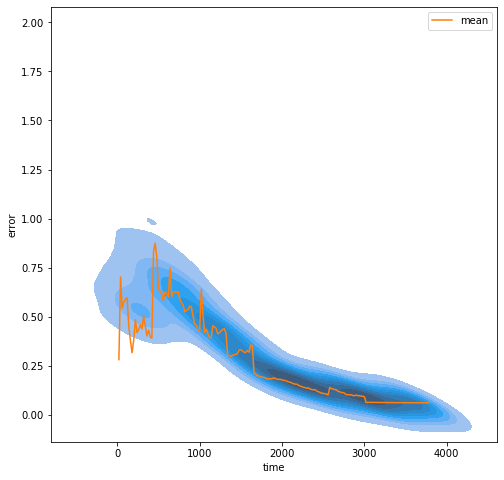

In [34]:
plt.figure(figsize=(8, 8))
sns.kdeplot(x='time', y='value', data=ensemble_tidy_df, fill=True)
plt.plot(ensemble_mean['time'], ensemble_mean['value'], label='mean')
plt.ylabel('error')
plt.legend()
plt.savefig(fig_dir + 'contourplot.pdf')
plt.show()

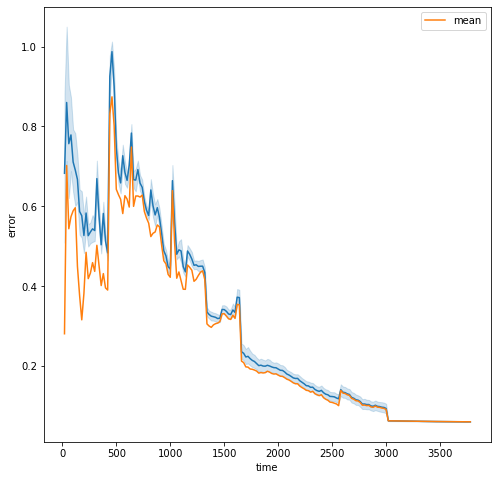

In [35]:
plt.figure(figsize=(8, 8))
sns.lineplot(x='time', y='value', data=ensemble_tidy_df)
plt.plot(ensemble_mean['time'], ensemble_mean['value'], label='mean')
plt.ylabel('error')
plt.legend()
plt.savefig(fig_dir + 'lineplot_ci.pdf')
plt.show()